#### Проект для "Викишоп" с BERT
Интернет-магазин "Викишоп" запускает новый сервис. Теперь пользователи могут редкатировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

1. Нужно обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

2. Нужно построить модель со значением метрики качества `F1` не меньше `0.75`. 

***Исходные данные:***

- `text` - в нём содержит текст комментария;
- `toxic` - целевой признак.

In [25]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import optuna
import transformers
from transformers import TFBertModel

from tqdm import tqdm
import ipywidgets as widgets

from sklearn.utils import resample
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import spacy
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version() if torch.backends.cudnn.is_available() else "Not available")
print("Device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available! PyTorch is using CPU.")

Torch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
cuDNN version: 90100
Device count: 1
GPU: NVIDIA GeForce RTX 3060


In [3]:
pth1 = '/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'
pth3 = 'C:/Users/abram/Downloads/toxic_comments.csv'

if os.path.exists(pth1):
    df_toxic = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_toxic = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df_toxic = pd.read_csv(pth3)  
else:
    print('Something is wrong')

In [4]:
df_toxic.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df_toxic = df_toxic.drop(columns=['Unnamed: 0'])

In [6]:
# Разделяем данные по классам
df_majority = df_toxic[df_toxic['toxic'] == 0]  # Нейтральные
df_minority = df_toxic[df_toxic['toxic'] == 1]  # Токсичные

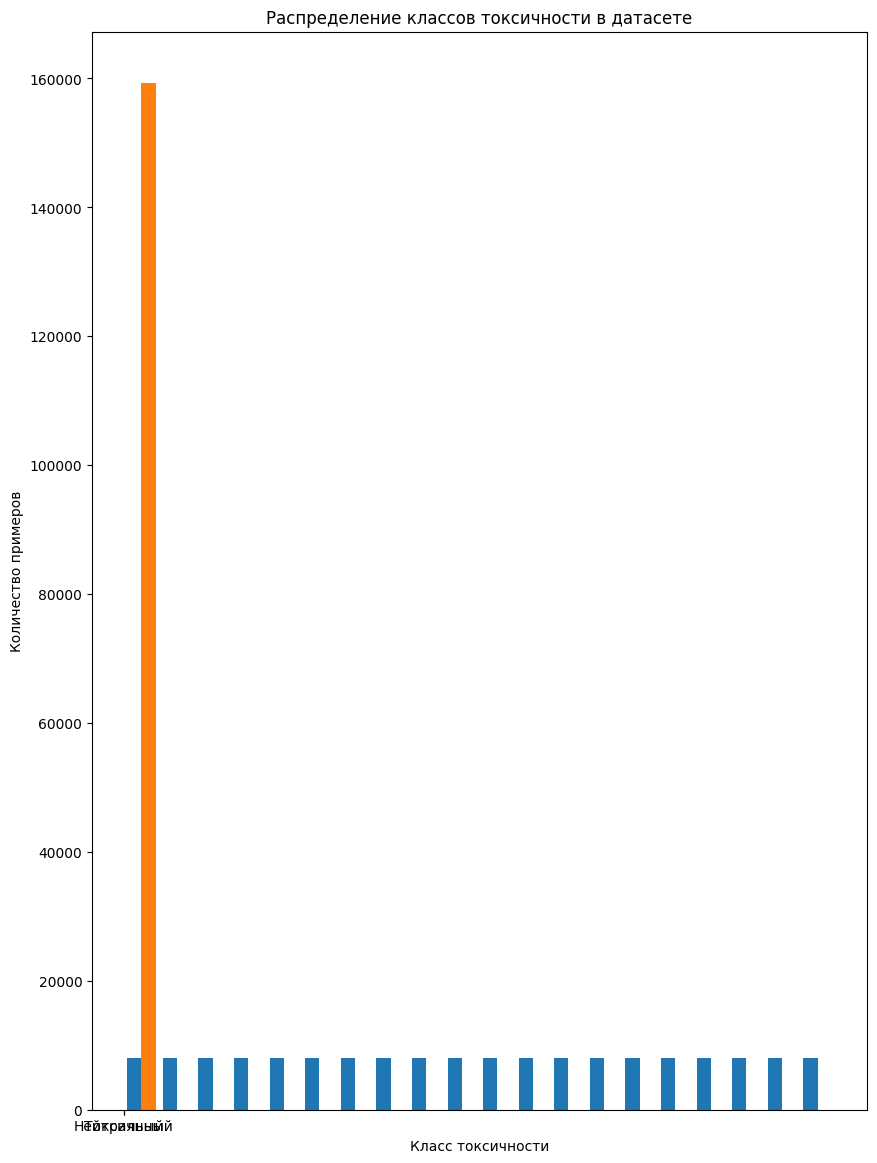

In [7]:
plt.figure(figsize=(10,14))
plt.hist(x=df_toxic, bins=20)

plt.xlabel("Класс токсичности")
plt.ylabel("Количество примеров")
plt.title("Распределение классов токсичности в датасете")
plt.xticks(ticks=[0, 1], labels=["Нейтральный", "Токсичный"])
plt.show()

In [8]:
df_majority

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [9]:
df_minority

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...
159215,"""\n\n our previous conversation \n\nyou fuckin...",1
159235,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159262,Your absurd edits \n\nYour absurd edits on gre...,1
159267,"""\n\nHey listen don't you ever!!!! Delete my e...",1


***Вывод по предобработке***

Основная проблема – `дисбаланс классов (значительно больше нетоксичных комментариев).`
**Решение** – undersampling (урезал большинство класса, чтобы классы были равны).

In [20]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [22]:
tokenized = df_balanced['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

max_len = 512  
padded = np.array([i[:max_len] + [0] * (max_len - len(i[:max_len])) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

print(f"padded.shape: {padded.shape}")
print(f"attention_mask.shape: {attention_mask.shape}")

padded.shape: (32372, 512)
attention_mask.shape: (32372, 512)


In [23]:
config = transformers.BertConfig.from_pretrained('bert-base-multilingual-cased')
model = transformers.BertModel.from_pretrained('bert-base-multilingual-cased')

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

***Подготовка данных для BERT***

BERT Tokenizer преобразовал текст в паддинговую матрицу и маску внимания, а BERT перенес на GPU для быстрого вычисления.

In [26]:
batch_size = 100
embeddings = []

# Обработка на GPU
for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i + 1)]).to(device)  
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i: batch_size * (i + 1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    # Переносим результаты обратно на CPU перед сохранением
    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

100%|██████████| 323/323 [10:14<00:00,  1.90s/it]


In [27]:
features = np.concatenate(embeddings)

X = features
y = df_balanced['toxic'][:X.shape[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

modelLog = LogisticRegression(class_weight='balanced', max_iter=1000)
modelLog.fit(X_train, y_train)

accuracy = modelLog.score(X_test, y_test)
print(f'Accuracy score - {accuracy}')

Accuracy score - 0.8482352941176471


In [28]:
y_pred = modelLog.predict(X_test)

f1score = classification_report(y_test, y_pred, digits=4)

print(f'F1 score:\n{f1score}')

F1 score:
              precision    recall  f1-score   support

           0     0.8469    0.8500    0.8484      8071
           1     0.8496    0.8465    0.8480      8079

    accuracy                         0.8482     16150
   macro avg     0.8482    0.8482    0.8482     16150
weighted avg     0.8482    0.8482    0.8482     16150



***Вывод по использованию BERT + Logistic Regression***

1. BERT + Logistic Regression показывает `F1-score ≈ 0.85`, что выполняет требования заказчика.

2. Сбалансированные `precision` и `recall` - модель хорошо распознаёт токсичные комментарии.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_toxic["text"], df_toxic["toxic"], test_size=0.3, random_state=42, stratify=df_toxic["toxic"]
)

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
def lemmatize_spacy(text):
    doc = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return lemm_text

In [13]:
X_train_lemmatized = X_train.apply(lemmatize_spacy)
X_test_lemmatized = X_test.apply(lemmatize_spacy)

In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=200000)

In [15]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_lemmatized)
X_test_tfidf = tfidf_vectorizer.transform(X_test_lemmatized)

In [16]:
print(f"TF-IDF train: {X_train_tfidf.shape}")
print(f"TF-IDF test: {X_test_tfidf.shape}")

TF-IDF train: (111504, 141748)
TF-IDF test: (47788, 141748)


In [17]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

***Использовал библиотеку spaCy для лемматизации текста, так как она работает быстрее аналогов. Создал матрицу TF-IDF.***

In [18]:
# Оптимизация для Logistic Regression
# Оптимизация для DecisionTreeClassifier
# Оптимизация для CatBoostClassifier
def objective(trial, model_type):
    if model_type == "logreg":
        C = trial.suggest_loguniform("C", 1e-3, 1e3)
        solver = trial.suggest_categorical("solver", ["lbfgs", "saga"])
        model = LogisticRegression(C=C, solver=solver, class_weight="balanced", max_iter=2000, random_state=42)

    elif model_type == "tree":
        max_depth = trial.suggest_int("max_depth", 3, 20)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced",
            random_state=42
        )

    elif model_type == "catboost":
        depth = trial.suggest_int("depth", 4, 12)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
        iterations = trial.suggest_int("iterations", 50, 100)
        model = CatBoostClassifier(
            depth=depth,
            learning_rate=learning_rate,
            iterations=iterations,
            verbose=0,
            random_seed=42
        )

    else:
        raise ValueError("Unknown model type")

    # Кросс-валидация с upsampling (SMOTE)
    f1_scores = []
    for train_index, val_index in kf.split(X_train_tfidf, y_train):
        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        smote = SMOTE(random_state=42)
        X_train_fold_bal, y_train_fold_bal = smote.fit_resample(X_train_fold, y_train_fold)

        model.fit(X_train_fold_bal, y_train_fold_bal)
        y_pred = model.predict(X_val_fold)

        f1_scores.append(f1_score(y_val_fold, y_pred))

    return np.mean(f1_scores)

In [19]:
study_log = optuna.create_study(direction="maximize")
study_log.optimize(lambda trial: objective(trial, "logreg"), n_trials=20)
print("Лучшие параметры для Logistic Regression:", study_log.best_params)

study_tree = optuna.create_study(direction="maximize")
study_tree.optimize(lambda trial: objective(trial, "tree"), n_trials=20)
print("Лучшие параметры для Decision Tree:", study_tree.best_params)

study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(lambda trial: objective(trial, "catboost"), n_trials=10)
print("Лучшие параметры для CatBoost:", study_cat.best_params)

[I 2025-03-20 20:11:44,789] A new study created in memory with name: no-name-515758ce-718d-458a-a73e-62bccc07dc19
C:\Users\abram\AppData\Local\Temp\ipykernel_10792\892907106.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-03-20 20:11:51,645] Trial 0 finished with value: 0.5324202600192912 and parameters: {'C': 0.025597783268396304, 'solver': 'saga'}. Best is trial 0 with value: 0.5324202600192912.
C:\Users\abram\AppData\Local\Temp\ipykernel_10792\892907106.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-03-20 20:12:04,988] Trial 1 finished with value: 0.6680

Лучшие параметры для Logistic Regression: {'C': 11.975541846016647, 'solver': 'lbfgs'}


[I 2025-03-20 20:18:33,764] Trial 0 finished with value: 0.5916071277148899 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5916071277148899.
[I 2025-03-20 20:19:25,520] Trial 1 finished with value: 0.6074387249469159 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6074387249469159.
[I 2025-03-20 20:20:09,888] Trial 2 finished with value: 0.594777905904501 and parameters: {'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.6074387249469159.
[I 2025-03-20 20:20:56,673] Trial 3 finished with value: 0.5916071277148899 and parameters: {'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.6074387249469159.
[I 2025-03-20 20:21:41,759] Trial 4 finished with value: 0.5953296772012723 and parameters: {'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 1 wit

Лучшие параметры для Decision Tree: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 5}


[I 2025-03-20 20:57:53,675] Trial 0 finished with value: 0.6974833083129881 and parameters: {'depth': 10, 'learning_rate': 0.052968822477109434, 'iterations': 85}. Best is trial 0 with value: 0.6974833083129881.
[I 2025-03-20 21:07:55,575] Trial 1 finished with value: 0.6997800146399089 and parameters: {'depth': 9, 'learning_rate': 0.08204757530149788, 'iterations': 78}. Best is trial 1 with value: 0.6997800146399089.
[I 2025-03-20 21:13:28,384] Trial 2 finished with value: 0.6971779942402199 and parameters: {'depth': 8, 'learning_rate': 0.0685547987084339, 'iterations': 79}. Best is trial 1 with value: 0.6997800146399089.
[I 2025-03-20 21:17:03,825] Trial 3 finished with value: 0.6913121999469322 and parameters: {'depth': 7, 'learning_rate': 0.05233689320963202, 'iterations': 83}. Best is trial 1 with value: 0.6997800146399089.
[I 2025-03-20 21:38:07,758] Trial 4 finished with value: 0.6811165662296977 and parameters: {'depth': 10, 'learning_rate': 0.029747149208721232, 'iterations': 

Лучшие параметры для CatBoost: {'depth': 11, 'learning_rate': 0.1564934925822418, 'iterations': 93}


In [20]:
models_scores = [
    ('LogReg', study_log.best_value),
    ('Tree', study_tree.best_value),
    ('CatBoost', study_cat.best_value)
]

best_model_name = None
best_f1 = -1

# Перебираем модели и находим лучшую по F1-score
for model_name, f1_score in models_scores:
    if f1_score > best_f1:
        best_model_name = model_name
        best_f1 = f1_score

print(f"Лучшая модель: {best_model_name} с F1-score на CV: {best_f1:.4f}")

Лучшая модель: CatBoost с F1-score на CV: 0.7207


In [21]:
# Обучаем только лучшую модель
if best_model_name == 'LogReg':
    final_model = LogisticRegression(**study_log.best_params, class_weight="balanced", max_iter=2000, random_state=42)
elif best_model_name == 'Tree':
    final_model = DecisionTreeClassifier(**study_tree.best_params, class_weight="balanced", random_state=42)
elif best_model_name == 'CatBoost':
    final_model = CatBoostClassifier(**study_cat.best_params, verbose=0, random_seed=42)

In [22]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# Обучаем лучшую модель
final_model.fit(X_train_balanced, y_train_balanced)

# Делаем предсказания на тестовой выборке
y_pred = final_model.predict(X_test_tfidf)

print(f"\nРезультаты на test для {best_model_name}:")
print(classification_report(y_test, y_pred, digits=4))


Результаты на test для CatBoost:
              precision    recall  f1-score   support

           0     0.9735    0.9574    0.9654     42932
           1     0.6713    0.7696    0.7171      4856

    accuracy                         0.9383     47788
   macro avg     0.8224    0.8635    0.8412     47788
weighted avg     0.9428    0.9383    0.9401     47788



In [28]:
def objective_lgbm(trial):
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 30, 150),
        "max_depth": trial.suggest_int("max_depth", 6, 25),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 5.0, log=True),
        "verbosity": -1,
        "scale_pos_weight": len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    }

    model = LGBMClassifier(**param)

    f1_scores = []
    for train_index, val_index in kf.split(X_train_tfidf, y_train):
        X_train_fold, X_val_fold = X_train_tfidf[train_index], X_train_tfidf[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        smote = SMOTE(random_state=42)
        X_train_fold_bal, y_train_fold_bal = smote.fit_resample(X_train_fold, y_train_fold)

        model.fit(X_train_fold_bal, y_train_fold_bal)
        y_pred = model.predict(X_val_fold)

        f1_scores.append(f1_score(y_val_fold, y_pred))

    return np.mean(f1_scores)

# Запуск оптимизации
print("\nОптимизируем LGBM...")
study_lgbm = optuna.create_study(direction="maximize", sampler=TPESampler())
study_lgbm.optimize(objective_lgbm, n_trials=10)

# Вывод лучших параметров
print(f"\nЛучшие параметры для LGBM: {study_lgbm.best_params}")
print(f"Лучший F1-score на CV: {study_lgbm.best_value:.4f}")

[I 2025-03-20 23:43:20,199] A new study created in memory with name: no-name-4e6297f3-8a9f-4ffd-8c02-dd7bb4ee668d



Оптимизируем LGBM...


c:\Users\abram\.conda\envs\machinelearn\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\abram\.conda\envs\machinelearn\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\abram\.conda\envs\machinelearn\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-03-20 23:44:02,494] Trial 0 finished with value: 0.3767648820978706 and parameters: {'learning_rate': 0.09814279034985664, 'num_leaves': 50, 'max_depth': 25, 'min_data_in_leaf': 30, 'reg_alpha': 0.02522435520539364, 'reg_lambda': 0.01426481380377407}. Best is trial 0 with value: 0.3767648820978706.
c:\Users\abram\.conda\envs\machinelearn\Lib\site-packages\sklearn\ut


Лучшие параметры для LGBM: {'learning_rate': 0.2537048406337495, 'num_leaves': 104, 'max_depth': 25, 'min_data_in_leaf': 23, 'reg_alpha': 3.3212254866233577, 'reg_lambda': 0.7790760118916901}
Лучший F1-score на CV: 0.5114


In [29]:
best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42)
best_lgbm.fit(X_train_tfidf, y_train)
y_pred_lgbm = best_lgbm.predict(X_test_tfidf)

print("Результаты на test для LGBM:")
print(classification_report(y_test, y_pred_lgbm, digits=4))

Результаты на test для LGBM:
              precision    recall  f1-score   support

           0     0.9632    0.9906    0.9767     42932
           1     0.8891    0.6654    0.7611      4856

    accuracy                         0.9576     47788
   macro avg     0.9261    0.8280    0.8689     47788
weighted avg     0.9557    0.9576    0.9548     47788



c:\Users\abram\.conda\envs\machinelearn\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## **1. Лучшая модель**  
**`LGBM (F1 = 0.7611 на классе 1, Accuracy = 0.9576)`**  
- LGBM показал наилучший баланс точности и скорости.  
- Обеспечивает высокую точность и обобщающую способность.  

## **2. `CatBoost` также показал хороший результат, но:**  
- Требует больше вычислительных мощностей для подбора гиперпараметров.  
- F1-score (0.7372) немного ниже, чем у LGBM, но все равно достойный результат.  
- Может быть полезен, если есть достаточно ресурсов для долгого обучения.  

## **3. `Decision Tree` не подходит**  
- Низкая точность.  
- Слабая обобщающая способность, переобучается на данных.  

## **4. `BERT + LogReg`**  
- Показал высокий F1-score для токсичных комментариев, но:  
  - Уступает TF-IDF по accuracy.  
  - Обучение значительно дольше, что делает его менее практичным.  

---

# **Рекомендация**
### **Финальная модель – `LGBM на TF-IDF`**  
Лучший баланс точности (**F1=0.7611**) и скорости обучения.  
Подходит для быстрого и эффективного детектирования токсичных комментариев.  

### **Если есть ресурсы, можно попробовать `CatBoost`**  
Может показать стабильные результаты, но требует больше вычислительных мощностей.  

### **`BERT + LogReg`**  
Вариант для более глубокого анализа, но требует дополнительных ресурсов.  